In [14]:
import pandas as pd
import os
import re
import numpy as np
from datetime import datetime
import seaborn as sns
import matplotlib.pyplot as plt

### Setup i/o

In [2]:
# set base directory
baseDIR = '/mnt/d'
# set input directory
inDIR = 'TBNG/data/veg/NEX'
# set input file
inXLSX = '2015-2021 Herb_16nov2021ep.xlsx'

### Load data

In [71]:
# create an Excel file object for investigating contents
nex_xlsx = pd.ExcelFile(os.path.join(baseDIR, inDIR, inXLSX))
# display the sheet names in the .xlsx file
display(nex_xlsx.sheet_names)

['Metadata 15-20',
 'VOR 15-20',
 'Basal 15-20',
 'Biomass-FQ 15-20',
 'Cover 15-20',
 'Pin Frame 16-20',
 'Pin_Calibration17-20',
 'Pin_CalibClip_Shrubs 17-18',
 'Grouse Pellets 15-19',
 'Ants 15-20',
 'Dung 15-20',
 'PDog_activity 17-20',
 'Fires',
 'SmMammExcl']

In [5]:
# Create the desired dataframes by parsing the individual sheets
df_nex_bm = nex_xlsx.parse(sheet_name='Biomass-FQ 15-20', header=1, usecols='C:AL')
df_nex_pf = nex_xlsx.parse(sheet_name='Pin_Calibration17-20', header=0)

### Clean data

#### Clean up dates

In [7]:
# create a mask to identify all values that are 'date-like'
dates_bm_mask = df_nex_bm['Date'].map(lambda x: bool(re.match('\d\d\d\d-\d\d-\d\d 00:00:00', str(x))))
# summarize to find all unique values in the 'Date' column for each year
dates_yrly_bm = pd.DataFrame(df_nex_bm.groupby('Year')['Date'].unique()).explode('Date')
# create a mask of 'date-like' values from the unique values pulled for each year
dates_yrly_bm_mask = dates_yrly_bm['Date'].map(lambda x: bool(re.match('\d\d\d\d-\d\d-\d\d 00:00:00', str(x))))
# create a Series of the 'date-like' unique values
dates_yrly_bm_good = dates_yrly_bm['Date'][dates_yrly_bm_mask].astype(np.datetime64)
# get the average date for each month of each year for manually correcting vague dates
dates_yrly_bm_avgs = dates_yrly_bm_good.groupby(['Year', dates_yrly_bm_good.dt.month_name()]).mean().dt.date

In [8]:
# display the average dates for each month of each year
display(dates_yrly_bm_avgs)

Year  Date  
2016  August    2016-08-02
      July      2016-07-08
2017  July      2017-07-19
2018  August    2018-08-03
      July      2018-07-16
      June      2018-06-16
2019  August    2019-08-06
      July      2019-07-16
      June      2019-06-25
2020  August    2020-08-06
      July      2020-07-07
2021  July      2021-07-07
      June      2021-06-30
Name: Date, dtype: object

In [9]:
# display the unique non-'date-like' values present in each year
display(dates_yrly_bm['Date'][~dates_yrly_bm_mask])

Year
2015                     na
2015           7/20-23/2015
2015          7/27-8/5/2015
2016           6/6-6/9/2016
2016          na, July 2016
2017          na, June 2017
2017          na, July 2017
2017        na, August 2017
2020    7/6/2020 - 7/7/2020
2020    7/8/2020 - 7/9/2020
2020      8/4/2020-8/5/2020
Name: Date, dtype: object

In [10]:
# create a dictionary to manually change non-'date-like' values to dates
dates_bm_dict = {
    2015: {
        'na': pd.to_datetime('2015-07-27').date(),
        '7/20-23/2015': pd.to_datetime('2015-07-21').date(),
        '7/27-8/5/2015': pd.to_datetime('2015-08-01').date()
    },
    2016: {
        'na, July 2016': dates_yrly_bm_avgs.loc[(2016, 'July')],
        '6/6-6/9/2016': pd.to_datetime('2016-06-08').date(),
    },
    2017: {
        'na, June 2017': pd.to_datetime('2017-06-22').date(),
        'na, July 2017': dates_yrly_bm_avgs.loc[(2017, 'July')],
        'na, August 2017': pd.to_datetime('2017-08-04').date(),
    },
    2020: {
        '7/6/2020 - 7/7/2020': pd.to_datetime('2020-07-07').date(),
        '7/8/2020 - 7/9/2020': pd.to_datetime('2020-07-09').date(),
        '8/4/2020-8/5/2020': pd.to_datetime('2020-08-05').date()
    }
}

In [11]:
# Create a new column of cleaned up dates from 'date-like' values and manual replacement
df_nex_bm.loc[dates_bm_mask, 
              'Date_cln'] = df_nex_bm['Date'][dates_bm_mask].astype(np.datetime64).dt.date
df_nex_bm.loc[~dates_bm_mask, 
              'Date_cln'] = df_nex_bm[~dates_bm_mask].apply(lambda x: dates_bm_dict[x.Year][x.Date], axis=1)

### Visualize data to check that it makes sense

<AxesSubplot:xlabel='Date_cln', ylabel='Total Weight (g/m^2)'>

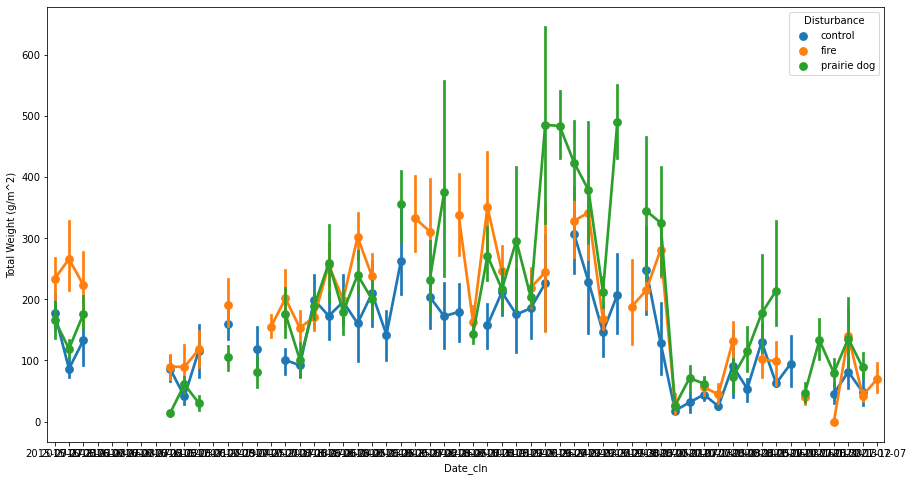

In [18]:
plt.figure(figsize=(15, 8))
sns.pointplot(x='Date_cln', y='Total Weight (g/m^2)', hue='Disturbance', data=df_nex_bm)

In [73]:
# Create a new column in the Pin Frame date pulling the nearest Biomass sampling date
df_nex_pf['Date_BM'] = df_nex_pf['Date'].map(lambda x: min(df_nex_bm['Date_cln'].unique(), key=lambda sub: abs(sub - x.date())))

In [74]:
# Check that all values in the newly created column are present in the Biomass dates
df_nex_pf['Date_BM'].sort_values().astype('str')[~df_nex_pf['Date_cln'].sort_values().isin(
    df_nex_bm[df_nex_bm['Year'] >= 2017]['Date_cln'])].unique()

array([], dtype=object)

### Compare Pin Frame and Biomass data